# 4D Image Segmentation

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import json 
import pandas as pd
import imageio

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K 
from IPython.display import Image, display
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
    Activation,
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    UpSampling2D,
)
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam

print(tf.__version__)

2.4.1


## Loading Data

In [2]:
root = os.getcwd()
print(root)

C:\Users\10699\Documents\Jupyter\4D_img_seg


In [3]:
data_dir = os.path.join(root, 'bdd100k_seg\seg')
img_dir = os.path.join(data_dir, 'images')
seg_dir = os.path.join(data_dir, 'color_labels')
labl_dir = os.path.join(data_dir,'labels')

In [4]:
train_img_dir = os.path.join(img_dir, 'train')
train_seg_dir = os.path.join(seg_dir, 'train')
train_labl_dir = os.path.join(labl_dir, 'train')

val_img_dir = os.path.join(img_dir, 'val')
val_seg_dir = os.path.join(seg_dir, 'val')
val_labl_dir = os.path.join(labl_dir, 'val')

In [5]:
def load_img(path, idx = 0):
    imgs = []
    names = os.listdir(path)
    
    for i in [idx] if type(idx) != list else idx:
        imgs.append(plt.imread(path + '\\' + names[i]))
    return np.squeeze(imgs)

In [6]:
def display_imgs(imgs, segs, labls):
    plt.figure(figsize = (15,15))
    plt.subplot(1,3,1)
    plt.imshow(imgs)
    plt.title('Image')
    
    plt.subplot(1,3,2)
    plt.imshow(segs)
    plt.title('Mask')
    
    plt.subplot(1,3,3)
    plt.imshow(labls,'gray')
    plt.title('Label')

In [7]:
def display_img_set(img_path = train_img_dir, seg_path = train_seg_dir, labl_path = train_labl_dir, idx = 0):
    imgs = load_img(img_path, idx)
    segs = load_img(seg_path, idx)
    labls = load_img(labl_path, idx)*255
    
    display_imgs(imgs, segs, labls)
    
    print('\t ', imgs.shape, '\t\t\t', segs.shape, '\t\t', labls.shape)
    return imgs, segs, labls.astype('uint8')

	  (720, 1280, 3) 			 (720, 1280, 3) 		 (720, 1280)


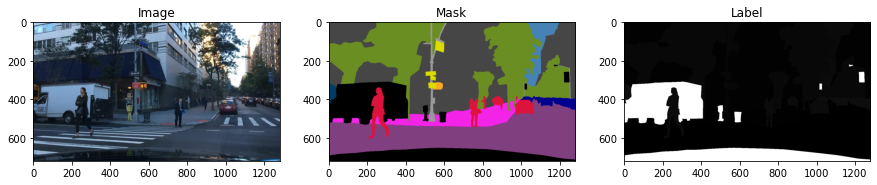

In [8]:
img, seg, labl = display_img_set(idx = 1)

In [ ]:
set(labl.ravel())

## Data Preprocessing

In [9]:
IMG_HEIGHT = 72
IMG_WIDTH = 128
IMG_DEPTH = 3
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
BATCH_SIZE = 4

N_CLASS = 20

In [10]:
def resize(img, H = IMG_HEIGHT, W = IMG_WIDTH, interp=cv2.INTER_NEAREST):
    return cv2.resize(img, (W, H), interpolation = interp)

In [11]:
def preprocess(img, mode = 'label'):
    if mode == "img":
        return resize(img)/255
    else:
        img = img * 255
        img = np.where(img == 255, 19, img)
        img = resize(img)
        label = keras.utils.to_categorical(img, num_classes=N_CLASS)
        return label

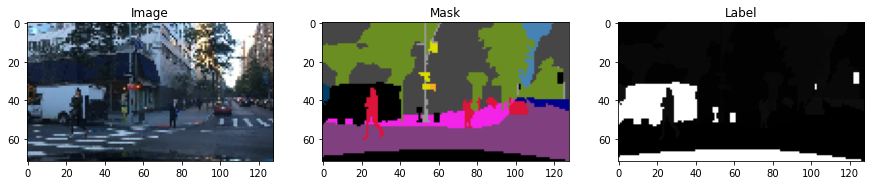

In [12]:
display_imgs(resize(img),resize(seg), resize(labl))

In [13]:
class DatasetGenerator(keras.utils.Sequence):
    def __init__(self, img_path, label_path, batch_size=BATCH_SIZE, shuffle=False, dim=(IMG_HEIGHT, IMG_WIDTH),
                 num_channels=3, num_classes=N_CLASS, verbose=0):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.img_path = img_path
        self.label_path = label_path
        self.dim = dim
        self.num_channels = num_channels
        self.num_classes = num_classes
        self.verbose = verbose
        self.sample_list = np.stack((os.listdir(img_path),os.listdir(label_path)),axis=-1)
        self.on_epoch_end()
        
    def on_epoch_end(self):
        'Updates indices after each epoch'
        self.indices = np.arange(len(self.sample_list))
        if self.shuffle == True:
            np.random.shuffle(self.indices)
            
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.sample_list) / self.batch_size))
    
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        X = np.zeros((self.batch_size, *self.dim, self.num_channels), dtype = np.float64)
        y = np.zeros((self.batch_size, *self.dim, self.num_classes), dtype = np.float64)

        for i, ID in enumerate(list_IDs_temp):
            if self.verbose == 1:
                print("Training on: %s" % '../train/' + ID)
            X[i] = preprocess(plt.imread(self.img_path+'\\'+ID[0]), 'img')
            y[i] = preprocess(plt.imread(self.label_path+'\\'+ID[1]), 'label')
        return X, y
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indices of the batch
        indices = self.indices[index * self.batch_size: (index + 1) * self.batch_size]
        # Find list of IDs
        sample_list_temp = [self.sample_list[k] for k in indices]
        # Generate data
        X, y = self.__data_generation(sample_list_temp)
        return X, y

In [14]:
def display_pair(img, label):
    plt.figure(figsize=(12,12))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title('Image')
    
    plt.subplot(1,2,2)
    plt.imshow(label, 'gray')
    plt.title('Label')

In [15]:
def display_one_batch(ds_gen, n=BATCH_SIZE):
    imgs, labels = next(iter(ds_gen))
    print(imgs.shape, labels.shape)
    
    for b in range(imgs.shape[0])[0:n]:
        display_pair(imgs[b], labels[b])
        print('\nSet of Labels[{}]:'.format(b))
        print(set(labels[b].ravel()))

In [16]:
train_generator = DatasetGenerator(train_img_dir, train_labl_dir, batch_size=4)
valid_generator = DatasetGenerator(val_img_dir, val_labl_dir, batch_size=4)

## Model Building

In [17]:
def soft_dice_loss(y_true, y_pred, axis=(1, 2), epsilon=1e-5):
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true**2, axis=axis) + K.sum(y_pred**2, axis=axis) + epsilon
    dice_loss = 1 - K.mean((dice_numerator)/(dice_denominator))

    return dice_loss

In [18]:
def dice_coefficient(y_true, y_pred, axis=(1, 2), epsilon=1e-5):
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true, axis=axis) + K.sum(y_pred, axis=axis) + epsilon
    dice_coefficient = K.mean((dice_numerator)/(dice_denominator))
 
    return dice_coefficient

In [19]:
def create_convolution_block(input_layer, n_filters, batch_normalization=False,
                             kernel=(3, 3), activation=None,
                             padding='same', strides=(1, 1),
                             instance_normalization=False):

    layer = Conv2D(n_filters, kernel, padding=padding, strides=strides)(
        input_layer)
    if activation is None:
        return Activation('relu')(layer)
    else:
        return activation()(layer)

In [20]:
def get_up_convolution(n_filters, pool_size, kernel_size=(2, 2),
                       strides=(2, 2),
                       deconvolution=False):
    if deconvolution:
        return Conv2DTranspose(filters=n_filters, kernel_size=kernel_size,
                               strides=strides)
    else:
        return UpSampling2D(size=pool_size)

In [21]:
def unet_model_3d(loss_function, input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH),
                  pool_size=(2, 2), n_labels=N_CLASS,
                  initial_learning_rate=0.000001,
                  deconvolution=False, depth=4, n_base_filters=32,
                  include_label_wise_dice_coefficients=False, metrics=[],
                  batch_normalization=False, activation_name="sigmoid"):
    
    inputs = Input(input_shape)
    current_layer = inputs
    levels = list()

    # add levels with max pooling
    for layer_depth in range(depth):
        layer1 = create_convolution_block(input_layer=current_layer,
                                          n_filters=n_base_filters * (
                                                  2 ** layer_depth),
                                          batch_normalization=batch_normalization)
        layer2 = create_convolution_block(input_layer=layer1,
                                          n_filters=n_base_filters * (
                                                  2 ** layer_depth) * 2,
                                          batch_normalization=batch_normalization)
        if layer_depth < depth - 1:
            current_layer = MaxPooling2D(pool_size=pool_size)(layer2)
            levels.append([layer1, layer2, current_layer])
        else:
            current_layer = layer2
            levels.append([layer1, layer2])

    # add levels with up-convolution or up-sampling
    for layer_depth in range(depth - 2, -1, -1):
        
        up_convolution = get_up_convolution(pool_size=pool_size,
                                            deconvolution=deconvolution,
                                            n_filters=K.int_shape(current_layer)[1])(current_layer)
        
        concat = concatenate([up_convolution, levels[layer_depth][1]], axis=-1)
        
        current_layer = create_convolution_block(n_filters= K.int_shape(levels[layer_depth][1])[1],
                                                 input_layer=concat, 
                                                 batch_normalization=batch_normalization)
        
        current_layer = create_convolution_block(n_filters= K.int_shape(levels[layer_depth][1])[1],
                                                 input_layer=current_layer,
                                                 batch_normalization=batch_normalization)

    final_convolution = Conv2D(n_labels, 1)(current_layer)
    act = Activation(activation_name)(final_convolution)
    model = Model(inputs=inputs, outputs=act)

    if not isinstance(metrics, list):
        metrics = [metrics]

    model.compile(optimizer=Adam(lr=initial_learning_rate), loss=loss_function, metrics=metrics)
    
    return model

In [22]:
# model = unet_model_3d(loss_function=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model = unet_model_3d(loss_function=soft_dice_loss, metrics=[dice_coefficient])

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 72, 128, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 72, 128, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 72, 128, 32)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 72, 128, 64)  18496       activation[0][0]                 
______________________________________________________________________________________________

## Training

In [25]:
#steps_per_epoch = 10
n_epochs=10
#validation_steps = 10

model.fit(train_generator,
        #steps_per_epoch=steps_per_epoch,
        epochs=n_epochs,
        #use_multiprocessing=True,
        validation_data=valid_generator,
        #validation_steps=validation_steps,
         verbose=1)

Epoch 1/10
1216/1216 [==============================] - 180s 142ms/step - loss: 0.6565 - dice_coefficient: 0.2948 - val_loss: 0.6884 - val_dice_coefficient: 0.2710
Epoch 2/10
1216/1216 [==============================] - 171s 140ms/step - loss: 0.6212 - dice_coefficient: 0.3272 - val_loss: 0.3687 - val_dice_coefficient: 0.5976
Epoch 3/10
1216/1216 [==============================] - 170s 140ms/step - loss: 0.3389 - dice_coefficient: 0.5910 - val_loss: 0.3605 - val_dice_coefficient: 0.5447
Epoch 4/10
1216/1216 [==============================] - 171s 141ms/step - loss: 0.3314 - dice_coefficient: 0.5506 - val_loss: 0.3625 - val_dice_coefficient: 0.5183
Epoch 5/10
1216/1216 [==============================] - 177s 146ms/step - loss: 0.3288 - dice_coefficient: 0.5586 - val_loss: 0.3602 - val_dice_coefficient: 0.5380
Epoch 6/10
1216/1216 [==============================] - 186s 153ms/step - loss: 0.3282 - dice_coefficient: 0.5765 - val_loss: 0.3612 - val_dice_coefficient: 0.5519
Epoch 7/10
1216/

In [42]:
#steps_per_epoch = 10
n_epochs=3
#validation_steps = 10

model.fit(train_generator,
        #steps_per_epoch=steps_per_epoch,
        epochs=n_epochs,
        #use_multiprocessing=True,
        validation_data=valid_generator,
        #validation_steps=validation_steps,
         verbose=1)

Epoch 1/3
250/250 [==============================] - 79s 316ms/step - loss: 0.3528 - dice_coefficient: 0.6169 - val_loss: 0.3519 - val_dice_coefficient: 0.6176
Epoch 2/3
250/250 [==============================] - 81s 323ms/step - loss: 0.3516 - dice_coefficient: 0.6174 - val_loss: 0.3512 - val_dice_coefficient: 0.6173ss: 0.3516 - dice_coe
Epoch 3/3
250/250 [==============================] - 80s 321ms/step - loss: 0.3510 - dice_coefficient: 0.6170 - val_loss: 0.3506 - val_dice_coefficient: 0.6171


In [59]:
model.save_weights(root + '/model_trained.hdf5')

## Model Evaluation

In [24]:
model.load_weights(root + '/model_trained.hdf5')

In [25]:
test_img_dir = os.path.join(img_dir, 'test')

In [26]:
Labels = {
    0: ["road", (128, 64, 128)],
    1: ["sidewalk", (244, 35, 232)],
    2: ["building", (70, 70, 70)],
    3: ["wall", (102, 102, 156)],
    4: ["fence", (190, 153, 153)],
    5: ["pole", (153, 153, 153)],
    6: ["traffic light", (250, 170, 30)],
    7: ["traffic sign", (220, 220, 0)],
    8: ["vegetation", (107, 142, 35)],
    9: ["terrain", (152, 251, 152)],
    10: ["sky", (70, 130, 180)],
    11: ["person", (220, 20, 60)],
    12: ["rider", (255, 0, 0)],
    13: ["car", (0, 0, 142)],
    14: ["truck", (0, 0, 70)],
    15: ["bus", (0, 60, 100)],
    16: ["train", (0, 80, 100)],
    17: ["motorcycle", (0, 0, 230)],
    18: ["bicycle", (119, 11, 32)],
    19: ["others", (0, 0, 0)],
}

### Evaluate on Validation Generator

In [27]:
model.evaluate(valid_generator)

1216/1216 [==============================] - 131s 105ms/step - loss: 0.2923 - dice_coefficient: 0.6694 - los


[0.2954811155796051, 0.6667034029960632]

### Evalute on An Image

In [28]:
def get_pred(img, model, rescale=True):
    predicted_labl_one_hot = model.predict(preprocess(img,'img')[np.newaxis,...])[0,...]
    predicted_labl = np.argmax(predicted_labl_one_hot, axis=-1).astype('uint8')
    if rescale:
        return resize(predicted_labl, H=720, W=1280)
    else:
        return predicted_labl

In [29]:
def get_pred_mask(pred, rescale=True, H=720, W=1280, interp=cv2.INTER_NEAREST):
    mask = np.zeros([pred.shape[0],pred.shape[1],3], dtype='uint8')
    for i in range(pred.shape[0]):
        for j in range(pred.shape[1]):
            mask[i,j] = Labels[pred[i,j]][1]
    if rescale:
        return resize(mask, H=H, W=W, interp=interp)
    return mask

In [30]:
def display_one_batch(img_path, labl_path, seg_path, model, idx = 0):
    img = load_img(img_path, idx=idx)
    labl = load_img(labl_path, idx=idx) * 255
    labl = labl.astype('uint8')
    mask = load_img(seg_path, idx=idx)
    
    pred_labl = get_pred(img, model)
    pred_mask = get_pred_mask(get_pred(img, model, False))
    
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('Image')
    
    plt.subplot(1,3,2)
    plt.imshow(labl, 'gray')
    plt.title('Target Label')
    
    plt.subplot(1,3,3)
    plt.imshow(pred_labl, 'gray')
    plt.title('Predicted Label')
    
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('Image')
    
    plt.subplot(1,3,2)
    plt.imshow(mask)
    plt.title('Target Mask')
    
    plt.subplot(1,3,3)
    plt.imshow(pred_mask)
    plt.title('Predicted Mask')

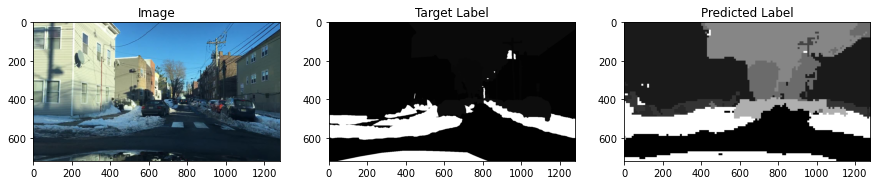

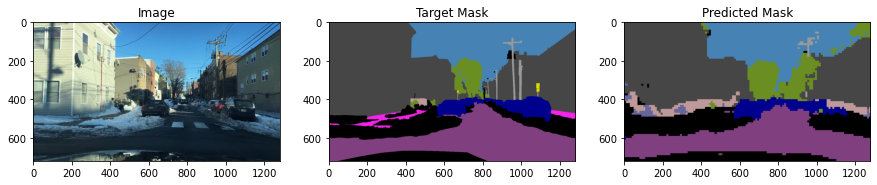

In [31]:
display_one_batch(val_img_dir, val_labl_dir, val_seg_dir, model)

###  - Evaluation Metrics

In [32]:
def evaluation_metrics(pred, label, class_num):
    class_pred = pred[...,class_num]
    class_label = label[...,class_num]

    tp = np.sum((class_pred == 1) & (class_label == 1))
    tn = np.sum((class_pred == 0) & (class_label == 0))
    fp = np.sum((class_pred == 1) & (class_label == 0))
    fn = np.sum((class_pred == 0) & (class_label == 1))

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    BA = (specificity+sensitivity)/2
    
    return sensitivity, specificity, BA

In [33]:
def get_eval_metrics(pred, label):
    label = np.where(label == 255, 19, label)
    label = keras.utils.to_categorical(label, num_classes=N_CLASS)
    pred = keras.utils.to_categorical(pred, num_classes=N_CLASS)
    
    classes = []
    label_vals = list(Labels.values())
    
    for i in range(N_CLASS):
        classes.append(label_vals[i][0])
    
    patch_metrics = pd.DataFrame(
        columns = classes, 
        index = ['Sensitivity',
                 'Specificity'])
    
    for i, class_name in enumerate(patch_metrics.columns):
        sens, spec, BA = evaluation_metrics(pred, label, i)
        patch_metrics.loc['Sensitivity', class_name] = round(sens,4)
        patch_metrics.loc['Specificity', class_name] = round(spec,4)
        patch_metrics.loc['Balanced Accuracy', class_name] = round(BA,4)

    return patch_metrics

In [34]:
pred = get_pred(img, model)
df = get_eval_metrics(pred, labl)
print(df)

<ipython-input-32-8de95a72b383>:10: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity = tp / (tp + fn)


                     road sidewalk building    wall   fence    pole  \
Sensitivity        0.9058   0.7664   0.6395     NaN     NaN  0.4737   
Specificity        0.9743   0.9877   0.8972  0.9992  0.9826  0.9923   
Balanced Accuracy    0.94    0.877   0.7683     NaN     NaN   0.733   

                  traffic light traffic sign vegetation terrain     sky  \
Sensitivity              0.4853        0.513     0.7635     NaN  0.7601   
Specificity              0.9995       0.9952     0.8865       1  0.9917   
Balanced Accuracy        0.7424       0.7541      0.825     NaN  0.8759   

                  person rider     car truck  bus train motorcycle bicycle  \
Sensitivity            0   NaN  0.9094   NaN    0   NaN        NaN     NaN   
Specificity            1     1  0.9842     1    1     1          1       1   
Balanced Accuracy    0.5   NaN  0.9468   NaN  0.5   NaN        NaN     NaN   

                   others  
Sensitivity        0.6617  
Specificity         0.963  
Balanced Accuracy

### Predict on Test Dataset

In [35]:
def visualize_test(img_dir, model, idx=0):
    img = load_img(img_dir, idx)
    pred_labl = get_pred(img, model, False)
    pred_mask = get_pred_mask(pred_labl, interp=cv2.INTER_AREA)
    pred_labl = resize(pred_labl, H=720, W=1280, interp=cv2.INTER_AREA)
    display_imgs(img, pred_mask, pred_labl)

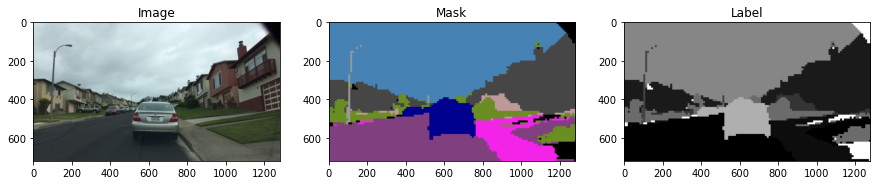

In [36]:
visualize_test(test_img_dir, model)

### Create Video

In [37]:
def dynamic_visualize(img_path, IDs, model, fname, T = 0.0001):
    imgs = []
    for ID in IDs:
        mask = get_pred_mask(get_pred(load_img(img_path, ID), model, False), H=180, W=320,interp=cv2.INTER_AREA)
        mask = cv2.GaussianBlur(mask,(5,5),0) 
        imgs.append(mask)
        
    imageio.mimsave(fname + ".gif", imgs, duration = T)
    return Image(fname + '.gif', format = 'png')

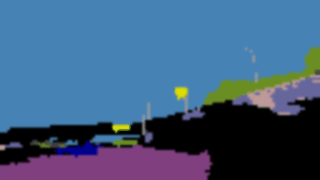

In [38]:
dynamic_visualize(train_img_dir, list(range(56,220)), model, 'pred_1')

In [39]:
def create_video(img_path, IDs, model, fname, H=720, W=1280):
    imgs = []
    for ID in IDs:
        mask = get_pred_mask(get_pred(load_img(img_path, ID), model, False), H=H, W=W, interp=cv2.INTER_AREA)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = cv2.GaussianBlur(mask,(5,5),0) 
        imgs.append(mask)
        
    video = cv2.VideoWriter(fname+'.avi', 0, 10, (W,H))
 
    for img in imgs:
        video.write(img)
    video.release()

In [40]:
create_video(train_img_dir, list(range(56,220)), model, 'pred_0')